First of all let's import all the libraries

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

2024-05-06 23:17:54.746344: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 23:17:54.804057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 23:17:55.771555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Dataset


In [2]:
df = pd.read_csv('/home/khangpt/MUSIC-GEN-PROJ/GTZAN/Data/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


We should first see how big our dataset is

In [3]:
df.shape

(1000, 60)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

Let's check whther our dataset is balanced or not

In [5]:
df['label'].value_counts()

label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64

So our dataset is balanced dataset

#### Correlation Heatmap for feature means

# Data Preprocessing

Let's convert the **label** values into integers

In [6]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

**Independent and dependent variables**

In [7]:
X = df.drop(['label','length','filename'],axis=1)
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(label_mapping)
y = df['label'] 

{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


# Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 57), (300, 57), (700,), (300,))

# Build ML Models using Sklearn library

Below code is taken from this [link](https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend)

In [9]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

We will going to make 11 models and then choose the best model

In [10]:

# Neural Nets
nn = make_pipeline(preprocessing.MinMaxScaler(),MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1))
model_assess(nn, "Neural Nets")



Accuracy Neural Nets : 0.56667 



/home/khangpt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


So we got highest accuracy with catboost model.Let's print the confusion matrix of it

Accuracy : 0.56667 



/home/khangpt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<Axes: >

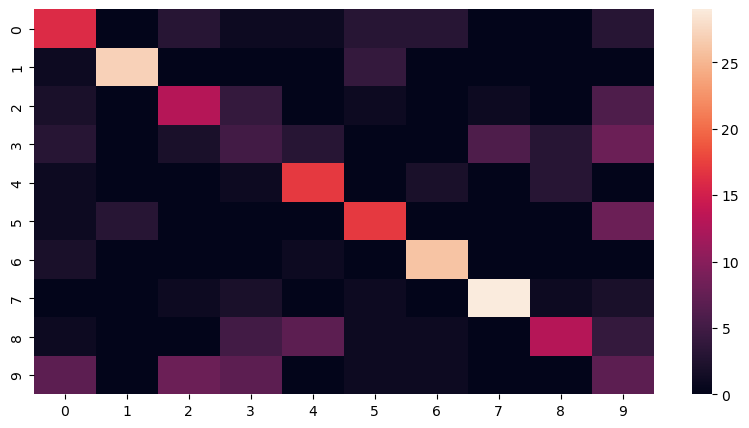

In [11]:
# Final model
cbc = make_pipeline(preprocessing.MinMaxScaler(),MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1))
cbc.fit(X_train, y_train)


preds = cbc.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confus_mat = confusion_matrix(y_test, preds) 
plt.figure(figsize = (10, 5))
sns.heatmap(confus_mat)

# Deep Learning Model using tensorflow's keras

Now it's time to build our deep learning model,so let's go ahead

In [12]:
X_train.shape[1]

57

In [13]:
norm_layer = Normalization(input_shape =X_train.shape[1:])
model = Sequential([
    norm_layer,
    Flatten(input_shape=(57,)),
    Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

/home/khangpt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/khangpt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# compile the model
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
split_index = int(0.8 * len(X_train))  # Calculate split index based on ratio



Wuhhoo our model is ready let's train our model,let's run for 1000 epochs

In [15]:
hist = model.fit(X_train, y_train,
                 epochs = 500,
                 batch_size = 32)

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1001 - loss: 78504.0938
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1110 - loss: 59482.8750
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1226 - loss: 46563.3086
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0943 - loss: 39397.8516
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1116 - loss: 31009.4727
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1025 - loss: 26821.1562
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1041 - loss: 24371.2617
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1062 - loss: 22244.1680
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0948 - loss: 19686.8652
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1180 - loss: 19590.0762
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1287 - loss: 15537.3340
Epoch 12/500
22/22 

In [18]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0760 - loss: 4.0249 
Test accuracy: 0.07999999821186066


# Plot Accuracy and Loss

In [17]:
def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()
plotHistory(hist)

KeyError: 'val_accuracy'

In [ ]:
predictions = model.predict(X_test).argmax(axis=-1)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy*100))
print(classification_report(y_test, predictions))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 8.00%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        30
           4       0.08      1.00      0.15        24
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00        31

    accuracy                           0.08       300
   macro avg       0.01      0.10      0.01       300
weighted avg       0.01      0.08      0.01       300



/home/khangpt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khangpt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khangpt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(model.predict(X[:15]).argmax(axis=-1))

# model.save("new_net.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
from sklearn.pipeline import make_pipeline 
neural_net = make_pipeline(preprocessing.MinMaxScaler(),model)
neural_net.predict(X[:15])

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.